In [1]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from PIL import Image
from ultralytics import YOLO
from IPython.display import Video

In [2]:
# Load a pretrained YOLOv8n model from Ultralytics
import torch
torch.load('yolov8n.pt')
from ultralytics.nn.tasks import DetectionModel

model = YOLO('yolov8n.pt')


image 1/1 E:\code\Car-Detection\project_data\sample_image.jpg: 384x640 5 cars, 33.0ms
Speed: 1.3ms preprocess, 33.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


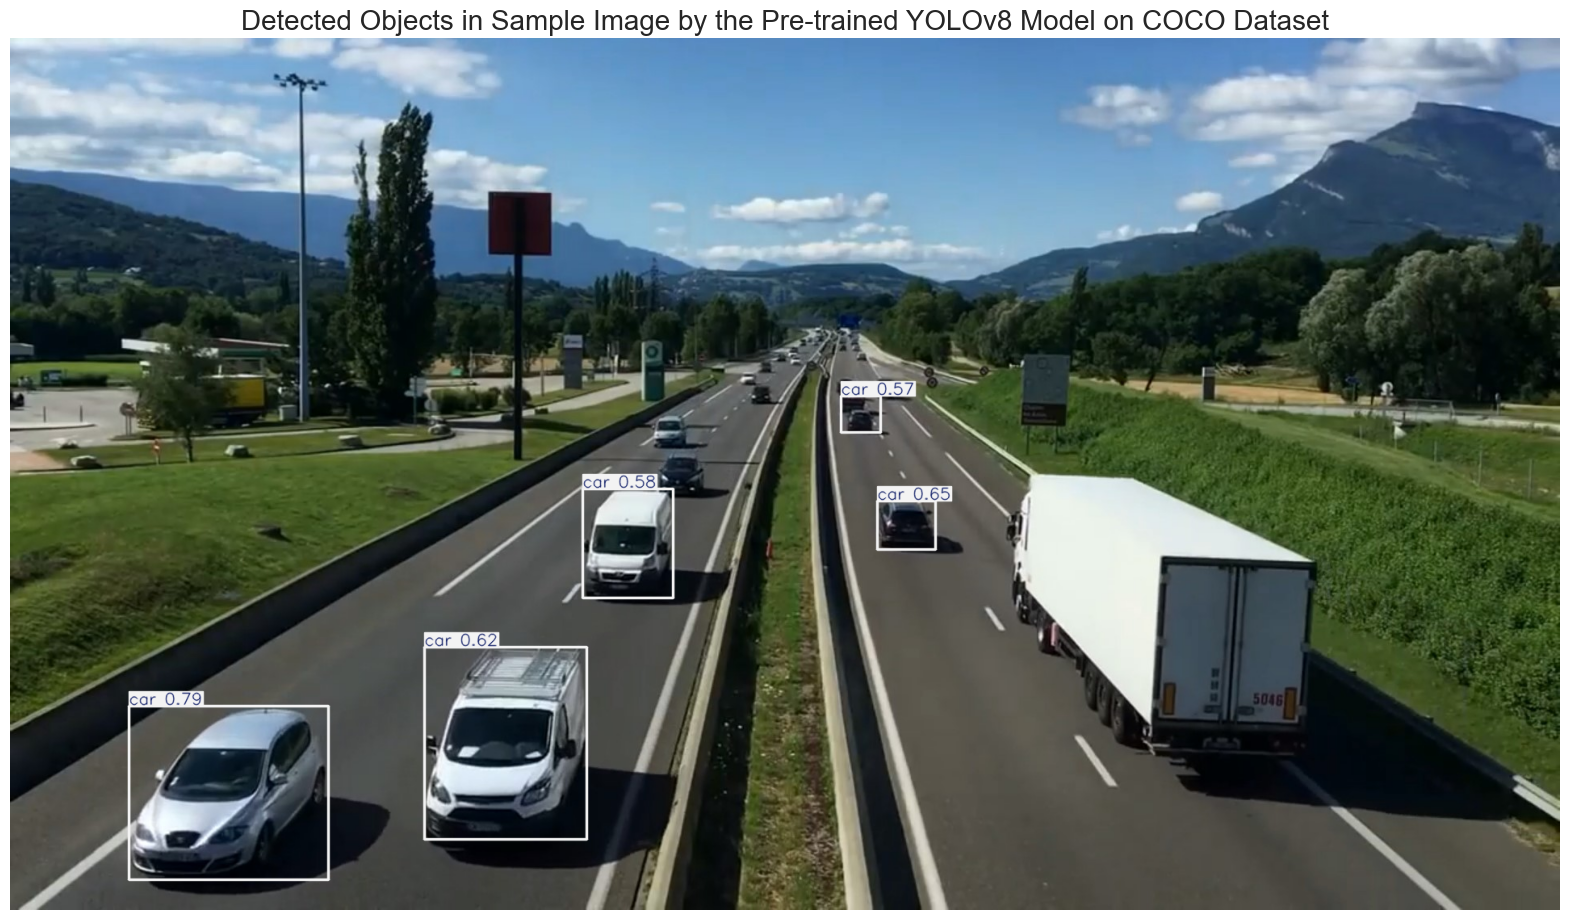

In [3]:
image_path = 'project_data/sample_image.jpg'

# Perform inference on the provided image(s)
results = model.predict(source=image_path, 
                        imgsz=640,  # Resize image to 640x640 (the size pf images the model was trained on)
                        conf=0.5)   # Confidence threshold: 50% (only detections above 50% confidence will be considered)

# Annotate and convert image to numpy array
#使用plot方法在检测结果上绘制边界框和标签，并将结果转换为NumPy数组。line_width=2参数设置了绘制边界框的线宽
#results[0]是指读入的图片放在列表的第一个位置
sample_image = results[0].plot(line_width=2)

# Convert the color of the image from BGR to RGB for correct color representation in matplotlib
#OpenCV默认使用BGR颜色空间，而matplotlib使用RGB颜色空间。因此，为了在matplotlib中正确显示颜色，需要将图片从BGR转换为RGB。
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# 创建一个新的matplotlib图形，设置图形的大小为20x15英寸。
plt.figure(figsize=(20,15))
plt.imshow(sample_image)
plt.title('Detected Objects in Sample Image by the Pre-trained YOLOv8 Model on COCO Dataset', fontsize=20)
#axis是坐标轴
plt.axis('off')
plt.show()

In [4]:
dataset_path = r"Dataset/Vehicle_Detection_Image_Dataset"
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

In [5]:
# Set paths for training and validation image sets
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
#下面这段代码是为了计数训练集和测试集中图片的数量以及判断他们的图片大小 是否一致的
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):  
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'): 
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 536
Number of validation images: 90
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


In [22]:
# Train the model on our custom dataset
#no need training again
if False:
    results = model.train(
        data=yaml_file_path,     # Path to the dataset configuration file
        epochs=100,              # Number of epochs to train for
        imgsz=640,               # Size of input images as integer
        device='cpu',                # Device to run on, i.e. cuda device=0 
        patience=50,             # Epochs to wait for no observable improvement for early stopping of training
        batch=32,                # 较大的batch size可以提高内存利用率和训练速度，但也可能导致模型训练的不稳定。较小的batch size可能使训练更稳定，但速度较慢。
        optimizer='auto',        # 
        lr0=0.0001,              # Initial learning rate 初始学习率，控制模型权重更新的步长。
        lrf=0.1,                 # Final learning rate (lr0 * lrf)最终学习率，通常与初始学习率相乘以实现学习率衰减。
        dropout=0.1,             # dropout比率，用于正则化以减少过拟合。
        seed=0                   # Random seed for reproducibility
    )

In [7]:
# Define the path to the directory
post_training_files_path = 'runs/detect/train'

# List the files in the directory
files_and_dirs = os.listdir(post_training_files_path)

In [8]:
# Define a function to plot learning curves for loss values
def plot_learning_curve(df, train_loss_col, val_loss_col, title):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='#141140', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='orangered', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [19]:
if False:# Create the full file path for 'results.csv' using the directory path and file name
    results_csv_path = os.path.join(post_training_files_path, 'results.csv')
    
    # Load the CSV file from the constructed path into a pandas DataFrame
    df = pd.read_csv(results_csv_path)
    
    # Remove any leading whitespace from the column names
    df.columns = df.columns.str.strip()
    
    # Plot the learning curves for each loss
    plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Box Loss Learning Curve')
    plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
    plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')


In [10]:
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')
best_model = YOLO(best_model_path)

metrics = best_model.val(data='./Dataset/Vehicle_Detection_Image_Dataset/data.yaml' ,split='val')
# C:\Users\19389\AppData\Roaming\Ultralytics\settings.json,如果有路径问题，可以修改这个文件做尝试。

# P：精确度（Precision）
# R：召回率（Recall）
# mAP50：平均精度均值（mean Average Precision at IoU=0.5）
# mAP50-95：平均精度均值（mean Average Precision at IoU=0.5:0.95）


Ultralytics 8.3.97  Python-3.10.16 torch-2.6.0+cpu CPU (AMD Ryzen 7 7745HX with Radeon Graphics)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 2.91MB/s]
val: Scanning E:\code\Car-Detection\Dataset\Vehicle_Detection_Image_Dataset\valid\labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 3414.26it/s]

val: New cache created: E:\code\Car-Detection\Dataset\Vehicle_Detection_Image_Dataset\valid\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


                   all         90        937      0.922      0.931      0.974       0.74
Speed: 1.0ms preprocess, 37.6ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\val18


In [14]:
# Convert the dictionary to a pandas DataFrame and use the keys as the index
metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

# Display the DataFrame
metrics_df.round(3)

,Metric Value
metrics/precision(B),0.922
metrics/recall(B),0.931
metrics/mAP50(B),0.974
metrics/mAP50-95(B),0.740
fitness,0.763



image 1/1 E:\code\Car-Detection\project_data\sample_image.jpg: 384x640 5 Vehicles, 55.7ms
Speed: 1.4ms preprocess, 55.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


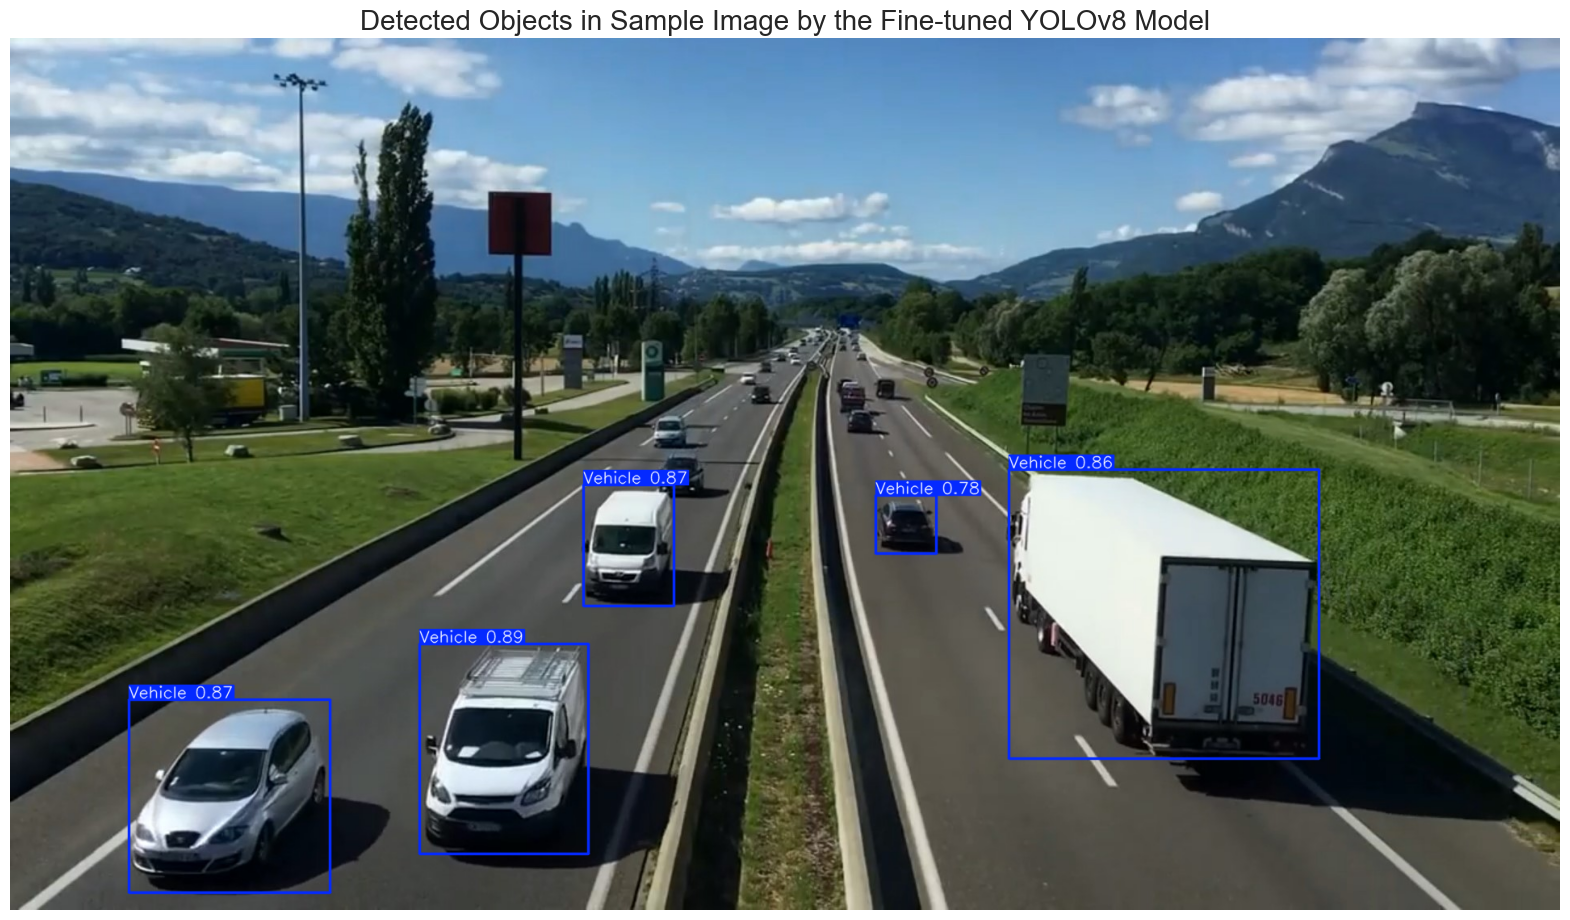

In [15]:
# Path to the image file
sample_image_path = 'project_data/sample_image.jpg'

# Perform inference on the provided image using best model
results = best_model.predict(source=sample_image_path, imgsz=640, conf=0.7) 
                        
# Annotate and convert image to numpy array
sample_image = results[0].plot(line_width=2)

# Convert the color of the image from BGR to RGB for correct color representation in matplotlib
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# Display annotated image
plt.figure(figsize=(20,15))
plt.imshow(sample_image)
plt.title('Detected Objects in Sample Image by the Fine-tuned YOLOv8 Model', fontsize=20)
plt.axis('off')
plt.show()



In [17]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import tkinter as tk
from tkinter import ttk, filedialog
from PIL import Image, ImageTk
import threading
import queue
import time
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

class FinalVehicleSpeedDetectionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("车辆速度检测系统")

        # 模型初始化
        self.model = YOLO("yolov8n.pt")  # 替换为你的模型路径
        self.tracker = DeepSort(max_age=30, n_init=3)
        self.conf_threshold = 0.5
        
        # 视频处理
        self.cap = None
        self.video_path = ""
        self.is_playing = False
        self.frame_count = 0
        self.fps = 30
        
        # 透视变换
        self.perspective_points = []
        self.M = None
        self.Minv = None
        self.real_world_scale = 0.3  # 米/像素（需实际标定）
        
        # 双线计数系统
        self.up_line = []
        self.down_line = []
        self.counter_up = 0
        self.counter_down = 0
        self.line_offset = 6
        
        # 车辆跟踪
        self.track_history = {}
        self.speed_history = {}
        
        # GUI组件
        self.create_widgets()
        self.setup_bindings()
        self.image_queue = queue.Queue(maxsize=1)

    def create_widgets(self):
        # 控制面板
        control_frame = ttk.Frame(self.root, padding=10)
        control_frame.pack(side=tk.TOP, fill=tk.X)

        self.btn_open = ttk.Button(control_frame, text="打开视频", command=self.open_video)
        self.btn_open.pack(side=tk.LEFT, padx=5)

        self.btn_calibrate = ttk.Button(control_frame, text="校准透视变换", 
                                     command=self.start_perspective_calibration)
        self.btn_calibrate.pack(side=tk.LEFT, padx=5)
        self.btn_calibrate.config(state=tk.DISABLED)

        self.btn_up_line = ttk.Button(control_frame, text="画上行线", 
                                    command=self.start_drawing_up_line)
        self.btn_up_line.pack(side=tk.LEFT, padx=5)
        self.btn_up_line.config(state=tk.DISABLED)

        self.btn_down_line = ttk.Button(control_frame, text="画下行线", 
                                      command=self.start_drawing_down_line)
        self.btn_down_line.pack(side=tk.LEFT, padx=5)
        self.btn_down_line.config(state=tk.DISABLED)

        # 置信度设置
        self.conf_frame = ttk.Frame(control_frame)
        self.conf_frame.pack(side=tk.LEFT, padx=10)
        ttk.Label(self.conf_frame, text="置信度:").pack(side=tk.LEFT)
        self.conf_entry = ttk.Entry(self.conf_frame, width=5)
        self.conf_entry.pack(side=tk.LEFT)
        self.conf_entry.insert(0, "0.5")
        ttk.Button(self.conf_frame, text="设置", 
                  command=self.set_conf_threshold).pack(side=tk.LEFT, padx=5)

        self.btn_start = ttk.Button(control_frame, text="开始检测", 
                                  command=self.toggle_detection)
        self.btn_start.pack(side=tk.LEFT, padx=5)
        self.btn_start.config(state=tk.DISABLED)

        # 视频画布
        self.canvas = tk.Canvas(self.root, bg='black', width=1020, height=500)
        self.canvas.pack(fill=tk.BOTH, expand=True)

        # 状态栏
        self.status_bar = ttk.Label(self.root, text="就绪", anchor=tk.W)
        self.status_bar.pack(side=tk.BOTTOM, fill=tk.X)

    def set_conf_threshold(self):
        try:
            conf = float(self.conf_entry.get())
            if 0 <= conf <= 1:
                self.conf_threshold = conf
                self.status_bar.config(text=f"置信度阈值已设置为: {conf:.2f}")
            else:
                self.status_bar.config(text="置信度需在0-1之间")
        except ValueError:
            self.status_bar.config(text="请输入有效数字")

    def setup_bindings(self):
        self.canvas.bind("<Button-1>", self.on_canvas_click)

    def open_video(self):
        file_path = filedialog.askopenfilename(filetypes=[("视频文件", "*.mp4 *.avi")])
        if file_path:
            self.video_path = file_path
            self.btn_calibrate.config(state=tk.NORMAL)
            self.load_first_frame()

    def load_first_frame(self):
        cap = cv2.VideoCapture(self.video_path)
        if cap.isOpened():
            ret, frame = cap.read()
            if ret:
                self.fps = cap.get(cv2.CAP_PROP_FPS)
                frame = cv2.resize(frame, (1020, 500))
                self.first_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                self.show_frame(self.first_frame)
                self.status_bar.config(text="请先进行透视变换校准（点击4个点，顺时针从左上角开始）")
            cap.release()

    def start_perspective_calibration(self):
        self.perspective_points = []
        self.drawing_mode = 'perspective'
        self.btn_calibrate.config(state=tk.DISABLED)
        self.status_bar.config(text="请点击4个点定义道路区域（顺时针从左上角开始）")

    def start_drawing_up_line(self):
        self.drawing_mode = 'up_line'
        self.temp_line_points = []
        self.status_bar.config(text="正在绘制上行线（蓝色），请点击两个点")

    def start_drawing_down_line(self):
        self.drawing_mode = 'down_line'
        self.temp_line_points = []
        self.status_bar.config(text="正在绘制下行线（红色），请点击两个点")

    def on_canvas_click(self, event):
        if self.drawing_mode == 'perspective' and len(self.perspective_points) < 4:
            self.perspective_points.append((event.x, event.y))
            self.canvas.create_oval(event.x-3, event.y-3, event.x+3, event.y+3, 
                                  fill='yellow', tags='calib_point')
            
            if len(self.perspective_points) == 4:
                self.calculate_perspective_matrix()
                self.btn_up_line.config(state=tk.NORMAL)
                self.btn_down_line.config(state=tk.NORMAL)
                self.btn_start.config(state=tk.NORMAL)
                self.drawing_mode = None
                
        elif self.drawing_mode in ('up_line', 'down_line'):
            self.temp_line_points.append((event.x, event.y))
            color = 'blue' if self.drawing_mode == 'up_line' else 'red'
            
            if len(self.temp_line_points) == 1:
                self.canvas.create_oval(event.x-3, event.y-3, event.x+3, event.y+3, 
                                      fill=color, tags='temp_line')
            elif len(self.temp_line_points) == 2:
                if self.drawing_mode == 'up_line':
                    self.up_line = self.temp_line_points
                    self.canvas.create_line(self.temp_line_points, fill=color, width=2, tags='up_line')
                else:
                    self.down_line = self.temp_line_points
                    self.canvas.create_line(self.temp_line_points, fill=color, width=2, tags='down_line')
                
                self.drawing_mode = None
                self.check_lines_status()

    def check_lines_status(self):
        if self.up_line and self.down_line:
            self.status_bar.config(text="校准完成，可以开始检测")
        else:
            line_type = "上行" if not self.up_line else "下行"
            self.status_bar.config(text=f"请继续绘制{line_type}线")

    def calculate_perspective_matrix(self):
        src = np.array(self.perspective_points, dtype=np.float32)
        width = int(max(np.linalg.norm(src[0]-src[1]), np.linalg.norm(src[2]-src[3])))
        height = int(max(np.linalg.norm(src[1]-src[2]), np.linalg.norm(src[3]-src[0])))
        
        dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)
        
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)
        self.status_bar.config(text=f"透视矩阵计算完成 区域尺寸：{width}x{height}像素")

    def transform_point(self, point):
        if self.M is not None:
            pt = np.array([[point]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(pt, self.M)
            return (transformed[0][0][0], transformed[0][0][1])
        return point

    def toggle_detection(self):
        if not self.is_playing:
            if not (self.up_line and self.down_line):
                self.status_bar.config(text="请先完成所有校准步骤")
                return
            self.is_playing = True
            self.btn_start.config(text="停止检测")
            self.start_detection()
        else:
            self.is_playing = False
            self.btn_start.config(text="开始检测")

    def start_detection(self):
        self.detection_thread = threading.Thread(target=self.process_video)
        self.detection_thread.daemon = True
        self.detection_thread.start()
        self.update_frame()

    def process_video(self):
        self.cap = cv2.VideoCapture(self.video_path)
        while self.is_playing and self.cap.isOpened():
            ret, frame = self.cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, (1020, 500))
            results = self.model.track(
                frame, 
                persist=True, 
                verbose=False,
                conf=self.conf_threshold,
                classes=[2, 3, 5, 7]  # 只检测车辆类别（根据COCO数据集）
            )
            
            # 获取检测结果
            boxes = results[0].boxes.xyxy.cpu().numpy()
            confs = results[0].boxes.conf.cpu().numpy()
            track_ids = results[0].boxes.id.int().cpu().tolist() if results[0].boxes.id is not None else []
            
            annotated_frame = frame.copy()

            # 绘制检测框和跟踪信息
            for box, conf, track_id in zip(boxes, confs, track_ids):
                x1, y1, x2, y2 = map(int, box)
                center = (int((x1+x2)/2), int((y1+y2)/2))
                
                # 绘制检测框
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0,255,0), 2)
                cv2.putText(annotated_frame, 
                          f"ID:{track_id} {conf:.2f}", 
                          (x1, y1-10), 
                          cv2.FONT_HERSHEY_SIMPLEX, 
                          0.6, (255,255,255), 2)

                # 更新轨迹历史
                if track_id not in self.track_history:
                    self.track_history[track_id] = []
                self.track_history[track_id].append(center)
                
                # 保留最近10个位置
                if len(self.track_history[track_id]) > 10:
                    self.track_history[track_id].pop(0)
                
                # 鸟瞰图速度计算
                if len(self.track_history[track_id]) >= 2:
                    pt1 = self.transform_point(self.track_history[track_id][-2])
                    pt2 = self.transform_point(self.track_history[track_id][-1])
                    
                    distance_px = np.linalg.norm(np.array(pt2) - np.array(pt1))
                    distance_m = distance_px * self.real_world_scale
                    time_diff = 1/self.fps  # 秒每帧
                    speed = distance_m / time_diff * 3.6  # km/h
                    
                    self.speed_history[track_id] = speed
                    
                    cv2.putText(annotated_frame, f"{speed:.1f} km/h", 
                               (x1, y1-35), cv2.FONT_HERSHEY_SIMPLEX, 
                               0.6, (0,255,255), 2)
                
                # 绘制运动轨迹
                for i in range(1, len(self.track_history[track_id])):
                    cv2.line(annotated_frame, 
                            self.track_history[track_id][i-1], 
                            self.track_history[track_id][i], 
                            (0,255,0), 2)
                
                # 检测线穿越
                self.check_line_crossing(track_id, center, annotated_frame)

            # 绘制检测线
            if self.up_line:
                cv2.line(annotated_frame, self.up_line[0], self.up_line[1], (255,0,0), 2)
            if self.down_line:
                cv2.line(annotated_frame, self.down_line[0], self.down_line[1], (0,0,255), 2)
            
            # 显示统计信息
            cv2.rectangle(annotated_frame, (0,0), (250,90), (0,255,255), -1)
            cv2.putText(annotated_frame, f"down: {self.counter_down}", (10,30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 1)
            cv2.putText(annotated_frame, f"up: {self.counter_up}", (10,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 1)

            img = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
            if self.image_queue.empty():
                try:
                    self.image_queue.put(img, block=False)
                except queue.Full:
                    pass

        self.cap.release()
        self.is_playing = False
        self.btn_start.config(text="开始检测")

    def check_line_crossing(self, track_id, center, frame):
        # 检测上行线穿越
        if self.up_line:
            y1, y2 = self.up_line[0][1], self.up_line[1][1]
            min_y = min(y1, y2) - self.line_offset
            max_y = max(y1, y2) + self.line_offset
            if min_y <= center[1] <= max_y:
                if track_id not in self.track_history or len(self.track_history[track_id]) < 2:
                    return
                prev_y = self.track_history[track_id][-2][1]
                if prev_y > max_y and center[1] <= max_y:
                    self.counter_up += 1
                    cv2.putText(frame, "上行计数+1", (center[0]+10, center[1]+30), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

        # 检测下行线穿越
        if self.down_line:
            y1, y2 = self.down_line[0][1], self.down_line[1][1]
            min_y = min(y1, y2) - self.line_offset
            max_y = max(y1, y2) + self.line_offset
            if min_y <= center[1] <= max_y:
                if track_id not in self.track_history or len(self.track_history[track_id]) < 2:
                    return
                prev_y = self.track_history[track_id][-2][1]
                if prev_y < min_y and center[1] >= min_y:
                    self.counter_down += 1
                    cv2.putText(frame, "下行计数+1", (center[0]+10, center[1]+30), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

    def show_frame(self, frame):
        img = Image.fromarray(frame)
        self.photo = ImageTk.PhotoImage(image=img)
        self.canvas.create_image(0, 0, image=self.photo, anchor=tk.NW)

    def update_frame(self):
        try:
            img = self.image_queue.get_nowait()
            self.show_frame(img)
        except queue.Empty:
            pass
        
        if self.is_playing:
            self.root.after(30, self.update_frame)

if __name__ == "__main__":
    root = tk.Tk()
    app = FinalVehicleSpeedDetectionApp(root)
    root.geometry("1020x600")
    root.mainloop()